In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Dropout, AveragePooling2D, concatenate, SeparableConv2D, Conv2D, BatchNormalization, ReLU, UpSampling2D
from tensorflow.keras import backend as K

def expend_as(tensor, rep):
    return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)

def gating_signal(input, out_size, batch_norm=False):
    """
    Resize the down layer feature map into the same dimension as the up layer feature map using 1x1 conv.
    :param input: Down-dim feature map.
    :param out_size: Output channel number.
    :param batch_norm: Whether to apply batch normalization.
    :return: The gating feature map with the same dimension as the up layer feature map.
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = layers.Conv2D(inter_shape, (1, 1), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), strides=(1, 1),padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([phi_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, ReLU, AveragePooling2D, concatenate, UpSampling2D, Conv2D, Dropout, Conv2DTranspose
from tensorflow.keras.initializers import glorot_uniform

class BasicConv(object):
    def __init__(self, out_planes, kernel_size):
        super(BasicConv, self).__init__()
        self.conv = Conv2D(
            out_planes,
            kernel_size=[kernel_size, kernel_size],
            strides=[1, 1],
            padding='same',
            kernel_initializer='glorot_uniform',
            use_bias=False,
            data_format='channels_last')  # Change to channels_last
        self.bn = BatchNormalization(
                axis=-1,
                momentum=0.999,
                epsilon=1e-5,
                fused=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = tf.nn.relu(x)
        return x

class ChannelPool(object):
    def forward(self, x):
        return tf.concat([tf.expand_dims(tf.reduce_max(x, axis=-1), axis=-1),
                          tf.expand_dims(tf.reduce_mean(x, axis=-1), axis=-1)], axis=-1)

class SpatialGate(object):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 3
        self.compress = ChannelPool()
        self.spatial = BasicConv(1, kernel_size)
    def forward(self, x):
        x_compress = self.compress.forward(x)
        x_out = self.spatial.forward(x_compress)
        scale = tf.nn.sigmoid(x_out)
        return x * scale

class TripletAttention(object):
    def __init__(self, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        print("Triplet Attention!")
        super(TripletAttention, self).__init__()
        self.ChannelGateH = SpatialGate()
        self.ChannelGateW = SpatialGate()
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()

    def forward(self, x):
        x_perm1 = tf.transpose(x, perm=[0, 2, 1, 3])
        x_out1 = self.ChannelGateH.forward(x_perm1)
        x_out11 = tf.transpose(x_out1, perm=[0, 2, 1, 3])
        x_perm2 = tf.transpose(x, perm=[0, 3, 2, 1])
        x_out2 = self.ChannelGateW.forward(x_perm2)
        x_out21 = tf.transpose(x_out2, perm=[0, 3, 2, 1])
        if not self.no_spatial:
            x_out = self.SpatialGate.forward(x)
            x_out = (1/3)*(x_out + x_out11 + x_out21)
        else:
            x_out = (1/2)*(x_out11 + x_out21)
        return x_out

def multi_unet_model(n_classes=4, IMG_HEIGHT=480, IMG_WIDTH=480, IMG_CHANNELS=3, use_bilinear_upsampling=True):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    def conv_block(x, filters, kernel_size=3, dilation_rate=1, dropout_rate=0.2):
        conv1 = SeparableConv2D(filters, kernel_size, padding='same', dilation_rate=dilation_rate)(x)
        conv1 = BatchNormalization()(conv1)
        conv1 = ReLU()(conv1)

        conv2 = SeparableConv2D(filters, kernel_size, padding='same', dilation_rate=dilation_rate)(conv1)
        conv2 = BatchNormalization()(conv2)
        conv2 = ReLU()(conv2)

        x = concatenate([conv1, conv2])

        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)

        return x

    def upsample_block(x, skip, filters, use_bilinear_upsampling, dropout_rate=0.2):
        gating = gating_signal(x, filters, batch_norm=True)
        att = attention_block(skip, gating, filters)
        if use_bilinear_upsampling:
          x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
        else:
          x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = concatenate([x, att], axis=-1)
        x = conv_block(x, filters, dropout_rate=dropout_rate)
        return x
    def upsample_block2(x, skip, filters, use_bilinear_upsampling, dropout_rate=0.2):
        if use_bilinear_upsampling:
          x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
        else:
          x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = concatenate([x, skip], axis=-1)
        x = conv_block(x, filters, dropout_rate=dropout_rate)
        return x

    # Contraction path
    c1 = conv_block(s, 32, dilation_rate=1, dropout_rate=0.2)
    p1 = AveragePooling2D((2, 2))(c1)

    c2 = conv_block(p1, 64, dilation_rate=1, dropout_rate=0.2)
    p2 = AveragePooling2D((2, 2))(c2)

    c3 = conv_block(p2, 128, dilation_rate=2, dropout_rate=0.2)
    p3 = AveragePooling2D((2, 2))(c3)

    c4 = conv_block(p3, 256, dilation_rate=2, dropout_rate=0.2)
    p4 = AveragePooling2D((2, 2))(c4)

    c5 = conv_block(p4, 512, dilation_rate=4, dropout_rate=0.3)

    # Expansion path with attention gates
    u6 = upsample_block(c5, c4, 256, use_bilinear_upsampling, dropout_rate=0.2)
    u7 = upsample_block(u6, c3, 128, use_bilinear_upsampling, dropout_rate=0.2)
    u8 = upsample_block(u7, c2, 64, use_bilinear_upsampling, dropout_rate=0.2)

    # Apply Triplet Attention to the skip connection between c1 and u8
    triplet_attention = TripletAttention()
    c1 = triplet_attention.forward(c1)
    print(c1.shape)
    u8 = triplet_attention.forward(u8)
    print(u8.shape)

    u9 = upsample_block2(u8, c1, 32, use_bilinear_upsampling, dropout_rate=0.2)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(u9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Usage:
model = multi_unet_model()
model.summary()




Triplet Attention!
(None, 480, 480, 64)
(None, 240, 240, 128)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 480, 480, 3)]        0         []                            
                                                                                                  
 separable_conv2d (Separabl  (None, 480, 480, 32)         155       ['input_1[0][0]']             
 eConv2D)                                                                                         
                                                                                                  
 batch_normalization (Batch  (None, 480, 480, 32)         128       ['separable_conv2d[0][0]']    
 Normalization)                                                                                   
                                

In [ ]:
!pip install patchify

In [ ]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.1 MB/s eta 0:00:00


In [ ]:

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Segmentation Models: using `tf.keras` framework.


In [ ]:

root_directory = '/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train'

patch_size = 480


Labels are:  [0 1 2 3]  and the counts are:  [5288202 3926480  249443 2535875]


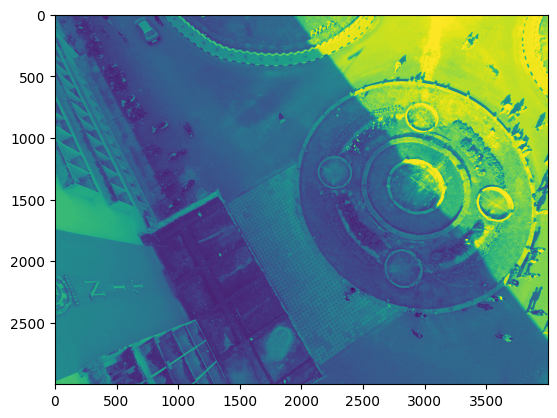

In [ ]:

# Verify the image path is correct and the file exists
image_path = "/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/images/NITR_AC_JAN26_29.png"
if not os.path.exists(image_path):
    print(f"Error: Image file not found at {image_path}")
else:
    temp_img = cv2.imread(image_path) #3 channels / spectral bands
    if temp_img is None:
        print(f"Error: Failed to load image from {image_path}. Check file format and permissions.")
    else:
        plt.imshow(temp_img[:,:,2]) #View each channel...
        temp_mask = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/gray_masks/NITR_AC_JAN26_29.png") #3 channels but all same.
        labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
        print("Labels are: ", labels, " and the counts are: ", count)

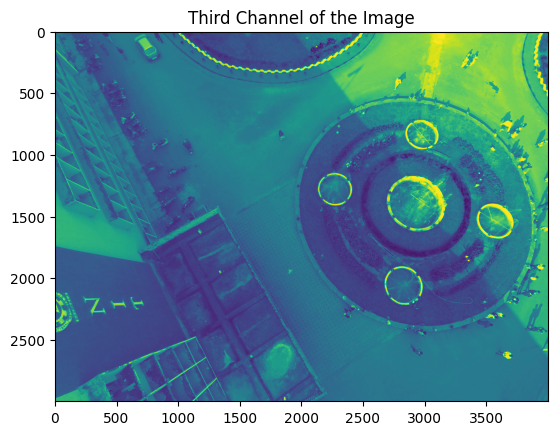

Labels are:  [0 1 2 3]  and the counts are:  [5288202 3926480  249443 2535875]


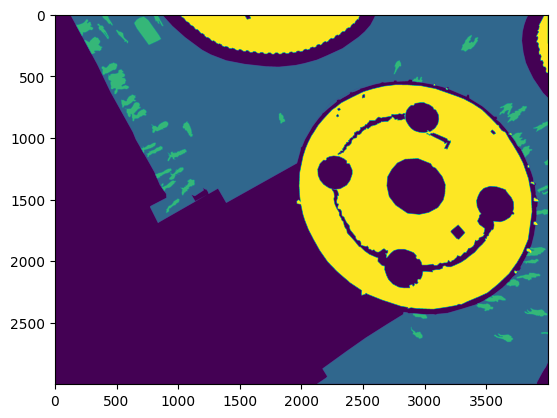

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# File paths
image_path = "/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/images/NITR_AC_JAN26_29.png"
mask_path = "/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/gray_masks/NITR_AC_JAN26_29.png"

# Read the image (3 channels / spectral bands)
temp_img = cv2.imread(image_path)
if temp_img is None:
    raise FileNotFoundError(f"Image file not found at {image_path}")

# Convert from BGR to RGB for display
temp_img_rgb = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)

# Display the third channel
plt.imshow(temp_img_rgb[:,:,2])
plt.title('Third Channel of the Image')
plt.show()

# Read the mask (3 channels but all are the same)
temp_mask = cv2.imread(mask_path, cv2.COLOR_BGR2RGB)
if temp_mask is None:
    raise FileNotFoundError(f"Mask file not found at {mask_path}")

# Check the unique labels and their counts in the mask
labels, counts = np.unique(temp_mask, return_counts=True)
print("Labels are: ", labels, " and the counts are: ", counts)
plt.imshow(temp_mask[:,:,])
plt.show()

In [ ]:
root_directory = '/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/'

patch_size = 480

#Read images from repsective 'images' subdirectory
#As all images are of different size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then
#divide all images into patches of 480x480x3.

patch_dir = root_directory + "480_patches/images/"
os.makedirs(patch_dir, exist_ok=True)
img_dir=root_directory+"images/"
for path, subdirs, files in os.walk(img_dir):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    #print(dirname)
    images = os.listdir(path)  #List of all image names in this subdirectory
    # print(images)
    for i, image_name in enumerate(images):
        if image_name.endswith(".png"):
            print(image_name)
            image_path = os.path.join(path, image_name)
            image = cv2.imread(image_path, 1)  #Read each image as BGR

            if image is None:
                print(f"Error reading image {image_path}")
                continue

            SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            image = np.array(image)

            #Extract patches from each image
            # print("Now patchifying image:", image_path)
            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):

                    single_patch_img = patches_img[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #We will preprocess using one of the backbones
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                    patch_name = f"{image_name}patch_{i}{j}.png"
                    patch_path = os.path.join(patch_dir, patch_name)
                    cv2.imwrite(patch_path, single_patch_img)
                    print(f"Saved patch: {patch_path}")


                    # cv2.imwrite(root_directory+"480_patches/images/"+
                    #            image_name+"patch_"+str(i)+str(j)+".png", single_patch_img)
                    #image_dataset.append(single_patch_img)


In [ ]:
import os
import cv2
import numpy as np
from patchify import patchify
from PIL import Image

root_directory = '/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/'
patch_size = 480

# Create directories for saving patches if they don't exist
mask_patch_dir = os.path.join(root_directory, "480_patches", "masks")
os.makedirs(mask_patch_dir, exist_ok=True)

mask_dir = os.path.join(root_directory, "gray_masks")
for path, subdirs, files in os.walk(mask_dir):
    masks = os.listdir(path)  # List of all mask names in this subdirectory

    for mask_name in masks:
        if mask_name.endswith(".png"):
            mask_path = os.path.join(path, mask_name)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read each image as Grayscale

            if mask is None:
                print(f"Error reading mask {mask_path}")
                continue

            SIZE_X = (mask.shape[1] // patch_size) * patch_size  # Nearest size divisible by our patch size
            SIZE_Y = (mask.shape[0] // patch_size) * patch_size  # Nearest size divisible by our patch size

            mask = Image.fromarray(mask)
            mask = mask.crop((0, 0, SIZE_X, SIZE_Y))  # Crop from top left corner
            mask = np.array(mask)

            # Extract patches from each mask
            print("Now patchifying mask:", mask_path)
            patches_mask = patchify(mask, (patch_size, patch_size), step=patch_size)  # Step=patch_size means no overlap

            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    single_patch_mask = patches_mask[i, j, :, :]  # Drop the extra unnecessary dimension that patchify adds
                    patch_name = f"{mask_name}patch_{i}{j}.png"
                    patch_path = os.path.join(mask_patch_dir, patch_name)

                    # Write the patch mask to the specified directory
                    cv2.imwrite(patch_path, single_patch_mask)
                    print(f"Saved mask patch: {patch_path}")


246 256
206


Text(0.5, 1.0, 'Mask')

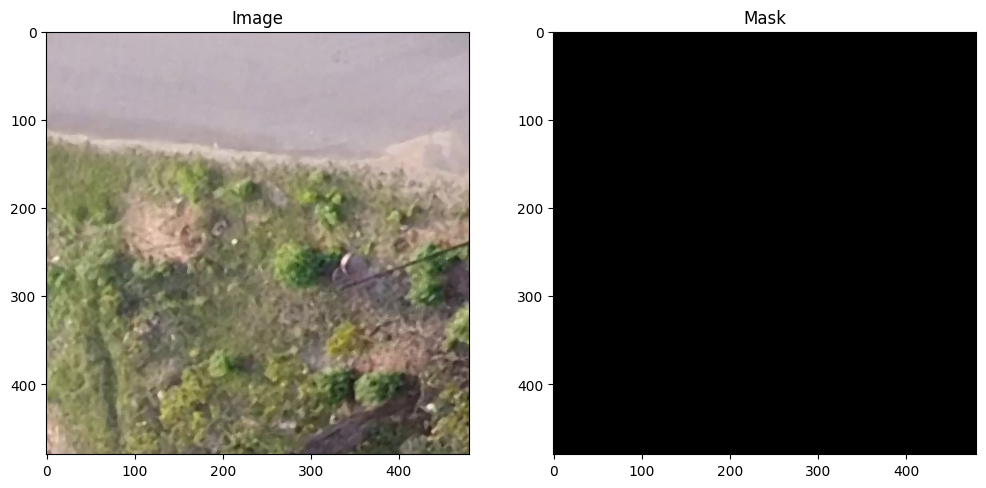

In [ ]:
train_img_dir = "/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/480_patches/images/"
train_mask_dir ="/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/480_patches/masks/"

import random

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)
img_list.sort() # Use the sort() method to sort the list in place
msk_list.sort()
print(len(img_list), len(msk_list))

num_images = len(os.listdir(train_mask_dir))


img_num = random.randint(0, num_images-1)
print(img_num)
img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')

In [ ]:
#Now, let us copy images and masks with real information to a new folder.
# real information = if mask has decent amount of labels other than 0.
patch_dir = root_directory + "480_patches/images_with_useful_info/images/"
os.makedirs(patch_dir, exist_ok=True)
patch_dir = root_directory + "480_patches/images_with_useful_info/masks/"
os.makedirs(patch_dir, exist_ok=True)

useless=0  #Useless image counter
for img in range(len(img_list)):   #Using t1_list as all lists are of same size
    img_name=img_list[img]
    mask_name = msk_list[img]
    # print("Now preparing image and masks number: "+ img_name, img)
    # print("Now preparing image and masks number: "+ mask_name)


    temp_image=cv2.imread(train_img_dir+img_list[img], 1)

    temp_mask=cv2.imread(train_mask_dir+msk_list[img], 0)
    #temp_mask=temp_mask.astype(np.uint8)

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.05:  #At least 5% useful area with labels that are not 0
        # continue
        print("Save Me")
        cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/480_patches/images_with_useful_info/images/'+img_name, temp_image)
        cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/480_patches/images_with_useful_info/masks/'+mask_name, temp_mask)
    else:
        # print("I am useless")
        useless +=1




In [ ]:
print("Total useful images are: ", len(img_list)-useless)  #20,075
print("Total useless images are: ", useless) #21,571

Total useful images are:  123
Total useless images are:  0


In [ ]:
pip install split-folders

In [ ]:
import splitfolders  # or import split_folders

input_folder = '/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/480_patches/images_with_useful_info'
output_folder = '/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/data_for_training_and_testing/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

123 123


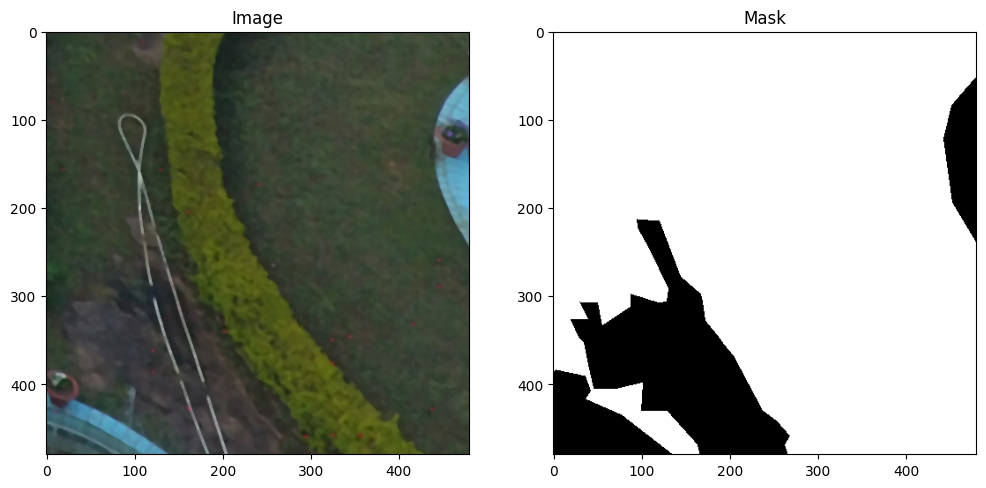

In [ ]:
train_img_dir = "/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/data_for_keras_aug/train_images/train/"
train_mask_dir = "/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/data_for_keras_aug/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)
img_list.sort() # Use the sort() method to sort the list in place
msk_list.sort()
print(len(img_list), len(msk_list))

num_images = len(os.listdir(train_img_dir))
seed=85

img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [ ]:
seed=24
batch_size= 4
n_classes=4

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc.
def preprocess_data(img, mask, num_class):
    #Scale images
    scaler = MinMaxScaler() # Initialize scaler outside the loop
    scaler.fit(img.reshape(-1, img.shape[-1])) # Fit the scaler once
    img = scaler.transform(img.reshape(-1, img.shape[-1])).reshape(img.shape) # Transform the image

    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class)

    return (img,mask)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):

    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        target_size=(480, 480),  # Set target size to 480x480
        class_mode = None,
        batch_size = batch_size,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        target_size=(480, 480),  # Set target size to 480x480
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        # print(img)
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)


In [ ]:

train_img_path = "/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/data_for_keras_aug/train_images/"
train_mask_path = "/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=4)

val_img_path = "/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/data_for_keras_aug/val_images/"
val_mask_path = "/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=4)

In [ ]:
x, y = train_img_gen.__next__()
x.shape, y.shape

Found 123 images belonging to 1 classes.
Found 123 images belonging to 1 classes.


((4, 480, 480, 3), (4, 480, 480, 4))

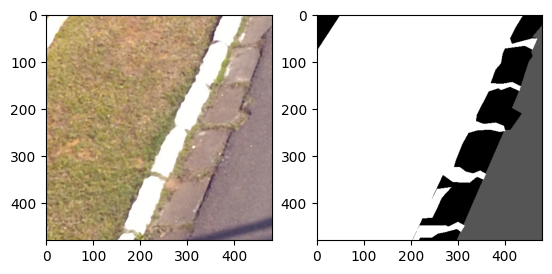

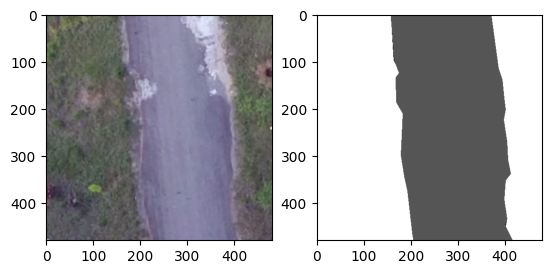

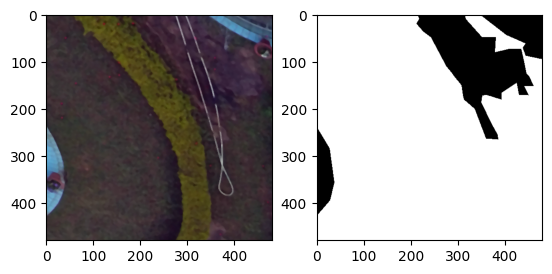

Found 42 images belonging to 1 classes.
Found 42 images belonging to 1 classes.


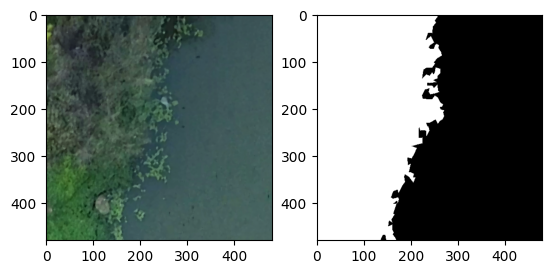

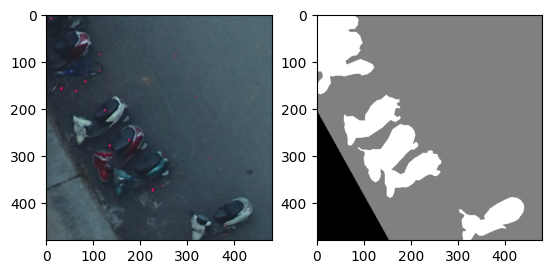

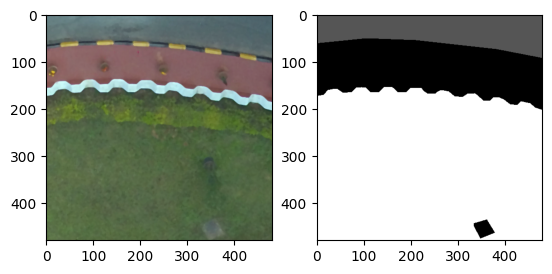

In [ ]:
for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [ ]:
num_train_imgs = len(os.listdir('/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/data_for_keras_aug/train_images/train/'))
num_val_images = len(os.listdir('/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/train/data_for_keras_aug/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
n_classes=4

In [ ]:

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
metrics=['accuracy', jacard_coef]
model = get_model()
# model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
# model.compile(optimizer='adam', loss='categorical_focal_loss', metrics=metrics
model.summary()

print(model.input_shape)

Triplet Attention!
(None, 480, 480, 64)
(None, 240, 240, 128)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 480, 480, 3)]        0         []                            
                                                                                                  
 separable_conv2d_18 (Separ  (None, 480, 480, 32)         155       ['input_2[0][0]']             
 ableConv2D)                                                                                      
                                                                                                  
 batch_normalization_27 (Ba  (None, 480, 480, 32)         128       ['separable_conv2d_18[0][0]'] 
 tchNormalization)                                                                                
                              

Epoch 1/50
30/30 [==============================] - 61s 1s/step - loss: 1.2062 - accuracy: 0.5140 - jacard_coef: 0.2545 - val_loss: 1.3435 - val_accuracy: 0.4659 - val_jacard_coef: 0.1503
Epoch 2/50
30/30 [==============================] - 29s 987ms/step - loss: 0.8186 - accuracy: 0.6854 - jacard_coef: 0.3970 - val_loss: 1.3093 - val_accuracy: 0.4755 - val_jacard_coef: 0.1560
Epoch 3/50
30/30 [==============================] - 31s 1s/step - loss: 0.7968 - accuracy: 0.6761 - jacard_coef: 0.4132 - val_loss: 1.2720 - val_accuracy: 0.3350 - val_jacard_coef: 0.1642
Epoch 4/50
30/30 [==============================] - 29s 973ms/step - loss: 0.6969 - accuracy: 0.7083 - jacard_coef: 0.4397 - val_loss: 1.2253 - val_accuracy: 0.4118 - val_jacard_coef: 0.1725
Epoch 5/50
30/30 [==============================] - 31s 1s/step - loss: 0.7064 - accuracy: 0.7265 - jacard_coef: 0.4531 - val_loss: 1.2227 - val_accuracy: 0.3630 - val_jacard_coef: 0.1775
Epoch 6/50
30/30 [==============================] - 29

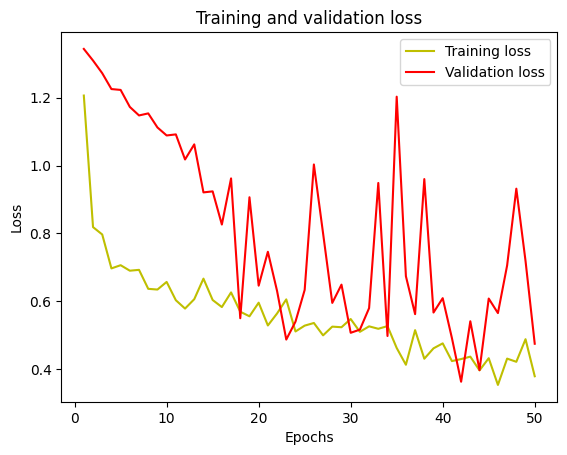

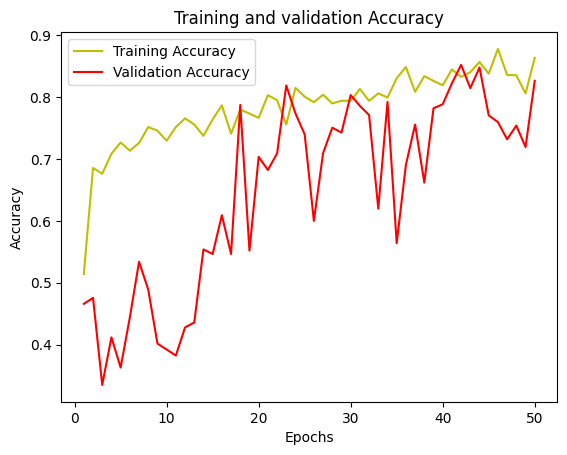

In [ ]:
# train_img_gen.reset()
# val_img_gen.reset()

history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
model.save('LW.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

from keras.models import load_model

model = load_model("LW.hdf5", compile=False)

In [ ]:

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


1/1 [==============================] - 0s 78ms/step
Mean IoU = 0.86509442


In [ ]:

#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)


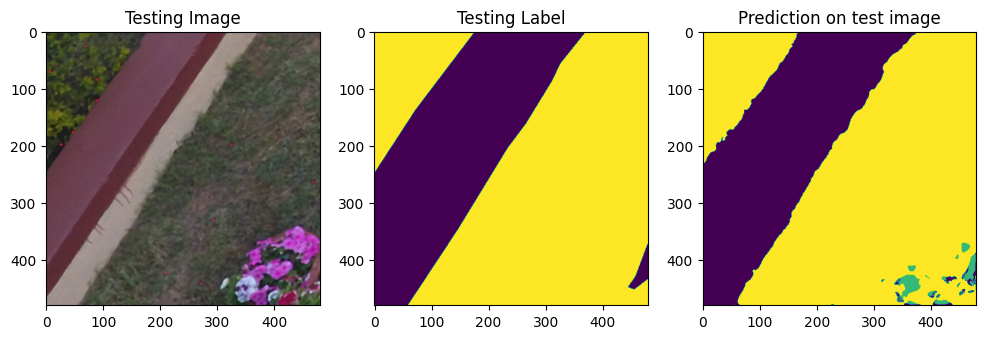

In [ ]:
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()

In [ ]:

"""

Original code is from the following source. It comes with MIT License so please mention
the original reference when sharing.

The original code has been modified to fix a couple of bugs and chunks of code
unnecessary for smooth tiling are removed.

# MIT License
# Copyright (c) 2017 Vooban Inc.
# Coded by: Guillaume Chevalier
# Source to original code and license:
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches/blob/master/LICENSE

"""
"""Perform smooth predictions on an image from tiled prediction patches."""


import numpy as np
import scipy.signal
from tqdm import tqdm

import gc


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    PLOT_PROGRESS = True
    # See end of file for the rest of the __main__.
else:
    PLOT_PROGRESS = False


def _spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind


cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    # Memoization
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.expand_dims(np.expand_dims(wind, 1), 1)      #SREENI: Changed from 3, 3, to 1, 1
        wind = wind * wind.transpose(1, 0, 2)
        if PLOT_PROGRESS:
            # For demo purpose, let's look once at the window:
            plt.imshow(wind[:, :, 0], cmap="viridis")
            plt.title("2D Windowing Function for a Smooth Blending of "
                      "Overlapping Patches")
            plt.show()
        cached_2d_windows[key] = wind
    return wind


def _pad_img(img, window_size, subdivisions):
    """
    Add borders to img for a "valid" border pattern according to "window_size" and
    "subdivisions".
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    # gc.collect()

    if PLOT_PROGRESS:
        # For demo purpose, let's look once at the window:
        plt.imshow(ret)
        plt.title("Padded Image for Using Tiled Prediction Patches\n"
                  "(notice the reflection effect on the padded borders)")
        plt.show()
    return ret


def _unpad_img(padded_img, window_size, subdivisions):
    """
    Undo what's done in the `_pad_img` function.
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug:-aug,
        aug:-aug,
        :
    ]
    # gc.collect()
    return ret


def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return mirrs


def _rotate_mirror_undo(im_mirrs):

    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)


def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):

    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)

    step = int(window_size/subdivisions)
    padx_len = padded_img.shape[0]
    pady_len = padded_img.shape[1]
    subdivs = []

    for i in range(0, padx_len-window_size+1, step):
        subdivs.append([])
        for j in range(0, pady_len-window_size+1, step):            #SREENI: Changed padx to pady (Bug in original code)
            patch = padded_img[i:i+window_size, j:j+window_size, :]
            subdivs[-1].append(patch)

    # Here, `gc.collect()` clears RAM between operations.
    # It should run faster if they are removed, if enough memory is available.
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()

    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()

    # Such 5D array:
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()

    return subdivs


def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    """
    Merge tiled overlapping patches smoothly.
    """
    step = int(window_size/subdivisions)
    padx_len = padded_out_shape[0]
    pady_len = padded_out_shape[1]

    y = np.zeros(padded_out_shape)

    a = 0
    for i in range(0, padx_len-window_size+1, step):
        b = 0
        for j in range(0, pady_len-window_size+1, step):                #SREENI: Changed padx to pady (Bug in original code)
            windowed_patch = subdivs[a, b]
            y[i:i+window_size, j:j+window_size] = y[i:i+window_size, j:j+window_size] + windowed_patch
            b += 1
        a += 1
    return y / (subdivisions ** 2)


def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, pred_func):

    pad = _pad_img(input_img, window_size, subdivisions)
    pads = _rotate_mirror_do(pad)


    res = []
    for pad in tqdm(pads):
        # For every rotation:
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(
            sd, window_size, subdivisions,
            padded_out_shape=list(pad.shape[:-1])+[nb_classes])

        res.append(one_padded_result)

    # Merge after rotations:
    padded_results = _rotate_mirror_undo(res)

    prd = _unpad_img(padded_results, window_size, subdivisions)

    prd = prd[:input_img.shape[0], :input_img.shape[1], :]

    if PLOT_PROGRESS:
        plt.imshow(prd)
        plt.title("Smoothly Merged Patches that were Tiled Tighter")
        plt.show()
    return prd



In [ ]:

import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# from smooth_tiled_predictions import predict_img_with_smooth_windowing



img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/val/images/NITR_AC_100.png")
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
input_img = preprocess_input(input_img)

original_mask = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/val/gray_masks/NITR_AC_100.png")
# original_mask = original_mask[:,:,0]  #Use only single channel...
original_mask = to_categorical(original_mask, num_classes=n_classes)

from keras.models import load_model
model = load_model("LW.hdf5", compile=False)

# size of patches
patch_size = 480

# Number of classes
n_classes = 4


###################################################################################
#Predict using smooth blending

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)


final_prediction = np.argmax(predictions_smooth, axis=2)

#Save prediction and original mask for comparison
plt.imsave('/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/segmented.jpg', final_prediction)
plt.imsave('/content/drive/MyDrive/Colab Notebooks/Lw-SegNet/data/mask.jpg', original_mask)
###################


plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(original_mask)
plt.subplot(223)
plt.title('Prediction with smooth blending')
plt.imshow(final_prediction)
plt.show()

#############################